In [ ]:
import math
import itertools
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from google.colab import files
import io
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


file=files.upload()

Saving bank-full.csv to bank-full.csv


In [ ]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
bank=pd.read_csv(io.BytesIO(file['bank-full.csv']))

In [ ]:
bank.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"58;""management"";""married"";""tertiary"";""no"";2143..."
1,"44;""technician"";""single"";""secondary"";""no"";29;""..."
2,"33;""entrepreneur"";""married"";""secondary"";""no"";2..."
3,"47;""blue-collar"";""married"";""unknown"";""no"";1506..."
4,"33;""unknown"";""single"";""unknown"";""no"";1;""no"";""n..."


In [ ]:
#First we have to fit the data into a dataframe
columns=bank.columns[0].replace('"', '')
columns=columns.split(';')
bank_df=pd.DataFrame(columns=columns)

In [ ]:
data=[]
for i in range(len(bank)):
  row=bank[bank.columns[0]][i].replace('"', '')
  data.append(row.split(';'))
  

In [ ]:
bank_df=pd.DataFrame(data, columns=columns)

In [ ]:
#Now we will remove the columns with too many null values, and drop the remaining rows with null values
bank_df.replace('unknown',np.nan, inplace= True)

bank_df.isnull().sum()

age              0
job            288
marital          0
education     1857
default          0
balance          0
housing          0
loan             0
contact      13020
day              0
month            0
duration         0
campaign         0
pdays            0
previous         0
poutcome     36959
y                0
dtype: int64

In [ ]:
bank_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [ ]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  object
 1   job        44923 non-null  object
 2   marital    45211 non-null  object
 3   education  43354 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  object
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    32191 non-null  object
 9   day        45211 non-null  object
 10  month      45211 non-null  object
 11  duration   45211 non-null  object
 12  campaign   45211 non-null  object
 13  pdays      45211 non-null  object
 14  previous   45211 non-null  object
 15  poutcome   8252 non-null   object
 16  y          45211 non-null  object
dtypes: object(17)
memory usage: 5.9+ MB


In [ ]:
#We will change the data types to integers and get dummies for the str columns
bank_df['age']=bank_df['age'].astype(int)
bank_df['balance']=bank_df['balance'].astype(int)
bank_df['duration']=bank_df['duration'].astype(int)
bank_df['campaign']=bank_df['campaign'].astype(int)
bank_df['pdays']=bank_df['pdays'].astype(int)
bank_df['previous']=bank_df['previous'].astype(int)

In [ ]:
bank_df.select_dtypes(include=['object'])

,job,marital,education,default,housing,loan,contact,day,month,poutcome,y
0,management,married,tertiary,no,yes,no,NaN,5,may,NaN,no
1,technician,single,secondary,no,yes,no,NaN,5,may,NaN,no
2,entrepreneur,married,secondary,no,yes,yes,NaN,5,may,NaN,no
3,blue-collar,married,NaN,no,yes,no,NaN,5,may,NaN,no
4,NaN,single,NaN,no,no,no,NaN,5,may,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,cellular,17,nov,NaN,yes
45207,retired,divorced,primary,no,no,no,cellular,17,nov,NaN,yes
45208,retired,married,secondary,no,no,no,cellular,17,nov,success,yes
45209,blue-collar,married,secondary,no,no,no,telephone,17,nov,NaN,no


In [ ]:
bank_df.drop(labels=['poutcome', 'contact'], axis=1, inplace=True)
bank_df.dropna(inplace=True)


In [ ]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43193 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        43193 non-null  int64 
 1   job        43193 non-null  object
 2   marital    43193 non-null  object
 3   education  43193 non-null  object
 4   default    43193 non-null  object
 5   balance    43193 non-null  int64 
 6   housing    43193 non-null  object
 7   loan       43193 non-null  object
 8   day        43193 non-null  object
 9   month      43193 non-null  object
 10  duration   43193 non-null  int64 
 11  campaign   43193 non-null  int64 
 12  pdays      43193 non-null  int64 
 13  previous   43193 non-null  int64 
 14  y          43193 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.3+ MB


In [ ]:
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['default'],prefix='default', drop_first= True)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['housing'],prefix='housing', drop_first= True)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['loan'],prefix='loan', drop_first= True)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['job'],prefix='job', drop_first= False)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['marital'],prefix='marital', drop_first= False)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['education'],prefix='education', drop_first= False)], axis=1)
bank_df=pd.concat([bank_df, pd.get_dummies(bank_df['y'],prefix='term deposit', drop_first= True)], axis=1)

In [ ]:
bank_df=bank_df.drop(labels=['default','marital', 'housing', 'day', 'month', 'education', 'marital', 'job', 'loan', 'y'], axis=1)


In [ ]:
bank_df

,age,balance,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,term deposit_yes
0,58,2143,261,1,-1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,44,29,151,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,33,2,76,1,-1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
5,35,231,139,1,-1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
6,28,447,217,1,-1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,977,3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1
45207,71,1729,456,2,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
45208,72,5715,1127,5,184,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
45209,57,668,508,4,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [ ]:
#bank_df.corr()['term deposit_yes'].sort_values()

AttributeError: ignored

In [ ]:
#Looking for any correlations between features or target
corr=bank_df.corr()
correlations=[]
for i in range(len(bank_df.columns)):
  cols=bank_df.columns
  col_corr=corr.loc[cols[i]].sort_values()
  cmin=col_corr[0]
  cmax=col_corr[25]
  corrs=[cols[i], col_corr.index[0], cmin, col_corr.index[25], cmax]
  correlations.append(corrs)


In [ ]:
#Looking at the least and most correlated features for each example and add the combination to the dataset
pd.DataFrame(correlations,columns=['Feature 1', 'Feature 2', 'Correlation 2', 'Feature 3', 'Correlation 3'] )

,Feature 1,Feature 2,Correlation 2,Feature 3,Correlation 3
0,age,marital_single,-0.425297,job_retired,0.448375
1,balance,loan_yes,-0.084378,age,0.097602
2,duration,campaign,-0.083118,term deposit_yes,0.397393
3,campaign,pdays,-0.088920,marital_married,0.030353
4,pdays,campaign,-0.088920,previous,0.452953
5,previous,campaign,-0.032381,pdays,0.452953
6,default_yes,balance,-0.066458,loan_yes,0.076025
7,housing_yes,age,-0.185152,job_blue-collar,0.173749
8,loan_yes,balance,-0.084378,default_yes,0.076025
9,job_admin.,job_blue-collar,-0.189245,education_secondary,0.223645


In [ ]:
feature_1=pd.DataFrame(bank_df['age']*bank_df['job_retired'], columns=['age x retired'])
feature_2=pd.DataFrame(bank_df['job_management']*bank_df['education_tertiary'], columns=['management x tert. ed'])
bank_df=pd.concat([bank_df, feature_1, feature_2], axis=1)
bank_df

,age,balance,duration,campaign,pdays,previous,default_yes,housing_yes,loan_yes,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,term deposit_yes,age x retired,management x tert. ed
0,58,2143,261,1,-1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
1,44,29,151,1,-1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0
2,33,2,76,1,-1,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
5,35,231,139,1,-1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
6,28,447,217,1,-1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,977,3,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0
45207,71,1729,456,2,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,71,0
45208,72,5715,1127,5,184,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,72,0
45209,57,668,508,4,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
#Random Forrest Classification

rfc = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
X = bank_df.drop(columns='term deposit_yes')
Y = bank_df['term deposit_yes']


print(f'{np.mean(cross_val_score(rfc, X, Y, cv=10))}\n')

0.8710422240659275



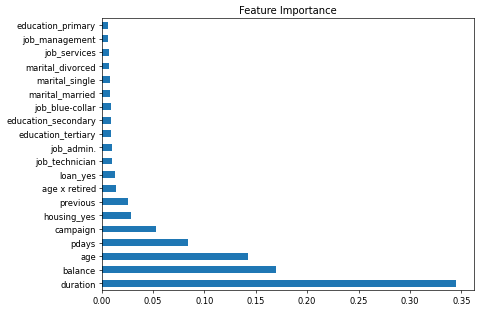

In [ ]:
from matplotlib.pyplot import figure
rfc.fit(X, Y)
figure(figsize=(8, 6), dpi=60)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Feature Importance')


In [ ]:
X.columns

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'default_yes', 'housing_yes', 'loan_yes', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_primary',
       'education_secondary', 'education_tertiary', 'age x retired',
       'management x tert. ed'],
      dtype='object')

In [ ]:
cols=list(X.columns[8:29])
cols.append(X.columns[6])
cols.append('term deposit_yes')
bank_df.drop(columns=cols)

,age,balance,duration,campaign,pdays,previous,housing_yes
0,58,2143,261,1,-1,0,1
1,44,29,151,1,-1,0,1
2,33,2,76,1,-1,0,1
5,35,231,139,1,-1,0,1
6,28,447,217,1,-1,0,1
...,...,...,...,...,...,...,...
45206,51,825,977,3,-1,0,0
45207,71,1729,456,2,-1,0,0
45208,72,5715,1127,5,184,3,0
45209,57,668,508,4,-1,0,0


In [ ]:
#dropping columns of low importance and reperforming test
rfc = ensemble.RandomForestClassifier(n_estimators=10, n_jobs=-1)
X = bank_df.drop(columns=cols)
Y = bank_df['term deposit_yes']


print(f'{np.mean(cross_val_score(rfc, X, Y, cv=10))}\n')

0.8664349708008541



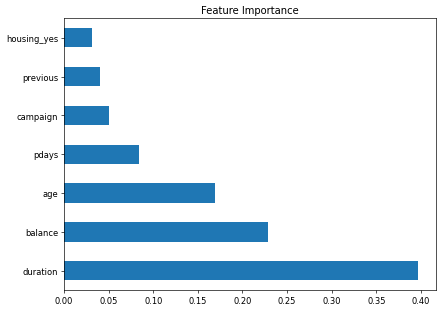

In [ ]:
rfc.fit(X, Y)

figure(figsize=(8, 6), dpi=60)

feat_importances = pd.Series(rfc.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', title='Feature Importance')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 465)


In [ ]:
scores=[]
for i in range(1,11):
  rfc = ensemble.RandomForestClassifier(n_estimators=i*10, n_jobs=-1)
  rfc.fit(X_train, y_train)
#  best=0
#  acc=rfc.score
#  if acc > best:
#    acc=best
  scores.append([i,np.mean(cross_val_score(rfc, X_train, y_train, cv=10))])



In [ ]:
#20 estimators looks like a good value to set, subsequent iterations have a negligible increase to cross_val_score
pd.DataFrame(scores)

,0,1
0,1,0.887217
1,2,0.890326
2,3,0.889797
3,4,0.890227
4,5,0.890921
5,6,0.892079
6,7,0.891484
7,8,0.890822
8,9,0.890789
9,10,0.891483


In [ ]:
#negligible difference when using entropy
rfc = ensemble.RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='entropy')
rfc.fit(X_train, y_train)
np.mean(cross_val_score(rfc, X_train, y_train, cv=10))

0.890061337505929

In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators=25, n_jobs=-1, criterion='gini')
rfc.fit(X_train, y_train)
np.mean(cross_val_score(rfc, X_train, y_train, cv=10))

0.8886390407230632

In [ ]:
y_preds = rfc.predict(X_test)

count=0
y_test=y_test.reset_index()['term deposit_yes']
for i in range(len(y_preds)):
  if y_preds[i]==y_test[i]:
    count+=1
  else:
    continue
count/len(y_preds)

0.8914956011730205

Confusion matrix, without normalization


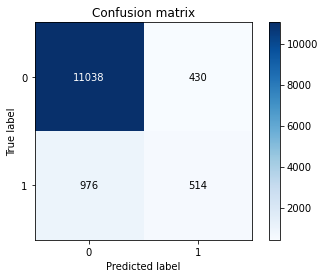

In [ ]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


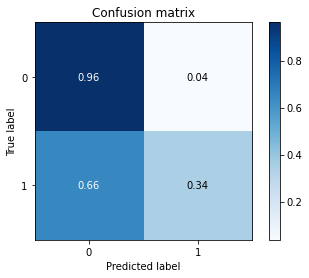

In [ ]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],True)

In [ ]:
RF_accuracy=rfc.score(X_test, y_test)
RF_precision=precision_score(y_test,y_preds)
RF_recall= recall_score(y_test,y_preds)

In [ ]:
#K-nearest neighbors
scores=[]
for i in range(1,20):
  neighbors = KNeighborsClassifier(n_neighbors=i)
  neighbors.fit(X_train,y_train)
  scores.append([i,np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))])

In [ ]:
#4 neighbors provides the best score and minimizes overfitting
pd.DataFrame(scores)

,0,1
0,1,0.850240
1,2,0.880536
2,3,0.876071
3,4,0.885100
4,5,0.881991
5,6,0.885398
6,7,0.884472
7,8,0.885861
8,9,0.885960
9,10,0.887448


In [ ]:
#uniformly weihted is better
neighbors = KNeighborsClassifier(n_neighbors=4, weights='distance')
neighbors.fit(X_train,y_train)
np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

0.8760045559003548

In [ ]:
#negligible differences

neighbors = KNeighborsClassifier(n_neighbors=4, weights='uniform', algorithm='ball_tree')
neighbors.fit(X_train,y_train)
A=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

neighbors = KNeighborsClassifier(n_neighbors=4, weights='uniform', algorithm='kd_tree')
neighbors.fit(X_train,y_train)
B=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

neighbors = KNeighborsClassifier(n_neighbors=4, weights='uniform', algorithm='brute')
neighbors.fit(X_train,y_train)
C=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

neighbors = KNeighborsClassifier(n_neighbors=4, weights='uniform', algorithm='auto')
neighbors.fit(X_train,y_train)
D=np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

print(A,B,C, D)


0.8851663699993175 0.8851002214941183 0.8851663699993175 0.8851002214941183


In [ ]:
neighbors = KNeighborsClassifier(n_neighbors=4, weights='uniform', algorithm='auto')
neighbors.fit(X_train, y_train)
np.mean(cross_val_score(neighbors, X_train, y_train, cv=10))

0.8851002214941183

In [ ]:
y_preds=neighbors.predict(X_test)

count=0
y_test=y_test.reset_index()['term deposit_yes']
for i in range(len(y_preds)):
  if y_preds[i]==y_test[i]:
    count+=1
  else:
    continue
count/len(y_preds)

0.884009878067603

Confusion matrix, without normalization


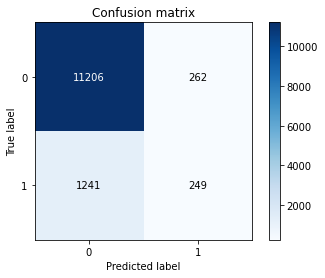

In [ ]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


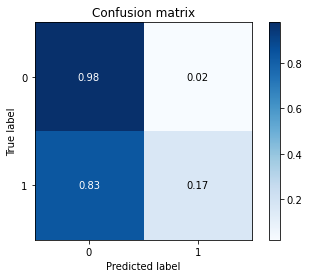

In [ ]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],True)

In [ ]:
KNN_accuracy=neighbors.score(X_test, y_test)
KNN_precision=precision_score(y_test,y_preds)
KNN_recall= recall_score(y_test,y_preds)

In [ ]:
#Gradient boosting classifier
scores=[]
for i in range(10,21):

  params = {'n_estimators': i*10,
            'max_depth': 3,
            'loss': 'deviance'}


  clf = ensemble.GradientBoostingClassifier(**params)
  clf.fit(X_train, y_train)
  scores.append([i,np.mean(cross_val_score(clf, X_train, y_train, cv=10))])

In [ ]:
pd.DataFrame(scores)

,0,1
0,10,0.896445
1,11,0.896147
2,12,0.896544
3,13,0.896147
4,14,0.896081
5,15,0.896213
6,16,0.896279
7,17,0.896246
8,18,0.896081
9,19,0.896114


In [ ]:
scores=[]
for i in range(2,6):

  params = {'n_estimators': 100,
            'max_depth': i,
            'loss': 'deviance'}


  clf = ensemble.GradientBoostingClassifier(**params)
  clf.fit(X_train, y_train)
  scores.append([i,np.mean(cross_val_score(clf, X_train, y_train, cv=10))])

In [ ]:
pd.DataFrame(scores)

,0,1
0,2,0.893567
1,3,0.896445
2,4,0.897867
3,5,0.896610


In [ ]:
params = {'n_estimators': 100,
          'max_depth': 4,
          'loss': 'exponential'}


clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
np.mean(cross_val_score(clf, X_train, y_train, cv=10))

0.8973375199309702

In [ ]:
scores=[]
for i in range(1,11):

  params = {'n_estimators': 100,
            'max_depth': 4,
            'loss': 'deviance',
            'learning_rate': i*.1}


  clf = ensemble.GradientBoostingClassifier(**params)
  clf.fit(X_train, y_train)
  scores.append([i,np.mean(cross_val_score(clf, X_train, y_train, cv=10))])

In [ ]:
pd.DataFrame(scores)

,0,1
0,1,0.897668
1,2,0.897007
2,3,0.895386
3,4,0.893766
4,5,0.892410
5,6,0.890822
6,7,0.888772
7,8,0.889532
8,9,0.886158
9,10,0.889763


In [ ]:
params = {'n_estimators': 100,
          'max_depth': 4,
          'loss': 'deviance',
          'learning_rate': .1}


clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)
np.mean(cross_val_score(clf, X_train, y_train, cv=10))

0.8976352264910815

In [ ]:
GB_accuracy=clf.score(X_test, y_test)
y_preds = clf.predict(X_test)
GB_precision=precision_score(y_test,y_preds)
GB_recall= recall_score(y_test,y_preds)

Confusion matrix, without normalization


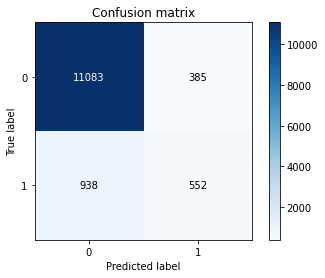

In [ ]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],False)

Normalized confusion matrix


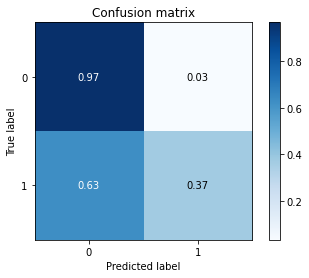

In [ ]:
cm = confusion_matrix(y_test, y_preds)
plot_confusion_matrix(cm,[0,1],True)

In [ ]:
data=[['Accuracy', RF_accuracy, KNN_accuracy, GB_accuracy], ['Precision', RF_precision, KNN_precision, GB_precision], ['Recall', RF_recall, KNN_recall, GB_recall]]
columns=['', 'Random Forest', 'K-Nearest Neighbor', 'Gradient Boosting']
summary=pd.DataFrame(data=data, columns=columns)

In [ ]:
summary

,,Random Forest,K-Nearest Neighbor,Gradient Boosting
0,Accuracy,0.891110,0.884010,0.898827
1,Precision,0.541799,0.487280,0.597601
2,Recall,0.343624,0.167114,0.367785


In [ ]:
#Gradient Boosting and Random Forest seem to be the best models for this data. All of these have similar accuracies, however K nearest neighbors
#has lower precision and recall. The confusion matrix indicates that there are slightly more false negatives as well. Gradient boosting is ideal to random forrest
#as there is a slightly improved accuracy and precision. Looking at the confusion matrices also tells us that Gradient boosting has less false negatives